# Importing library

In [ ]:
import CESSIPy_modRenan as SSI 
from MRPy import MRPy #Library with modal analysis functions
import auxFunctions_postProcessEMMARM as auxEMMARM #Library with auxiliary functions for EMM-ARM post processing
import numpy as np 
from scipy.signal import detrend, welch, resample, decimate
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd

#Module for selecting files
from tkinter import Tk, filedialog

#Module to deal with files from the system
import os

from scipy.signal import detrend, welch, resample, decimate
#To find peaks
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


: 

In [ ]:
#Global variables
typeOfProcessing = ['singleFile','batchProcessing']
typeOfSystem = ['uEMMARM','National','old_uEMMARM','RPi']
fileTypes = [('.emm files', '*.emm'), ('text files', '*.txt'), ('CSV files', '*.csv')]

: 

# Global configuration

In [ ]:
#File naming option
resultFilePreffix = 'uEMMARM-4-Empty' #Preffix to be added to the beginning of the result file
headerResultFiles = '3RD BATCH PAPER UEMMARM \n'

# Selection options
selectedProcessing = typeOfProcessing[1] #Options: ['singleFile','batchProcessing']
selectedSystem = typeOfSystem[0] #Options: ['uEMMARM','National','old_uEMMARM','RPi]
desiredChannel = 1 #Number of variables in the file. For example, National test files may have four channels

#Calibration factor of the sensor used to convert test file reading to g's
calibrationFactor = 1 #This is for National
#calibrationFactor = 1/2400 #This is for commercial ADXL335

# Sampling frequency
samplingFrequencyOriginal=1000 #In Hz. Not used by uEMMARM, which is based on a fixed duration of measurement session, automatically obtained from test files
# Length of window for PSD/FFT
nps = 4096

#Filter configuration
#See documentation about the function
filterConfiguration = { 1: {'filter': 'detrend', 'type': 'linear'},
                        3: {'filter': 'butterworth', 'order': 8, 'type': 'bandpass', 'frequencies': [8,35]}}

#Selection of modal identification methods
modalIdentificationMethod_SingleAnalysis = {'peak-picking':True, 'BFD':True, 'EFDD':True, 'SSI-COV':True}
modalIdentificationMethod_BatchAnalysis = {'peak-picking':True, 'BFD':False, 'EFDD':False, 'SSI-COV':True}

#Peak-picking method
#Interval for averaging around the peak for the average peak-picking method
intervalForAveragingHz = 0.1

#EFDD method
EFFDfint = [0.5, 1.5] #This specifies the interval around the peak frequency used to compute the autocorrelation function. Specified in % of the peak frequency
EFFDtint = np.array([0.05,1]) #This specifies initial and final time interval used to fit the theoretical autocorrelation function. Specified in seconds

#SSI Configuration
numModesToBeConsidered=3 # This variable specifies how many modes will be considered in SSI identification. For standard EMM-ARM, we need only 1 (allegedly if the experiment was correctly performed, it will refer to the first frequency)
i    = 60 # number of time lags. From Peeters: The number of block rows i of Href should be such that r i >= nmax, which is the maximum model order.
startingOrderNumber = 2 # The order number by which the SSI method will start
endOrderNumber = 60 # The order number by which the SSI method will end
incrementBetweenOrder = 1 # The increment between each iteration
refs = [0] # reference sensors (all three are ref.)
stabcrit = {'freq':0.03, 'damping': 0.15, 'mac':0.02}
# This is defined based on what is expectable from tests
valid_range={'freq': [50, 35*4*2], 'damping':[0.001, 0.10]}
# tolerance for SSI methods
tol = np.array(([0.001,8, 35],     # [allowed_variation, lower_bound, higher_bound]: eigenfrequencies
                [0.15,0.001,.05],   # [allowed_variation, lower_bound, higher_bound]: damping ratios
                [0.02,0,1]))        # [allowed_variation, lower_bound, higher_bound]: MAC

#Base configuration for plot
plotConfiguration={'typeForPSD': 'Single_PSD', 'frequencyBand': [0,100], 'ylimForPSD': [1e-10,None], 'typeForEFDD': 'only_ANPSD', 'ylimForEFDD': [None,1], 'typeForBFD':True, 'typeForEFDD': 'Autocorrelation-SVD', 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'figSizeBFD': (5,5), 'figSizeEFDD': (5,5), 'typeForStabilizationDiagram': 'StabilizationPSD', 'figSizeStabilization': (7,7), 'dpi': 150}

plotConfiguration_Batch={'typeForPSD': False, 'frequencyBand': [0,100], 'ylimForPSD': [1e-10,None], 'typeForEFDD': False, 'ylimForEFDD': [None,1], 'typeForBFD':False, 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'figSizeBFD': (5,5), 'figSizeEFDD': (5,5), 'typeForStabilizationDiagram': False, 'figSizeStabilization': (7,7), 'dpi': 150}

: 

# Validation of variables

In [ ]:
# Define the type of file to be read
if selectedSystem == "uEMMARM":
    selectedFileType = fileTypes[0]
    selectedFileExtension = selectedFileType[1][-4:]
elif selectedSystem == "National":
    selectedFileType = fileTypes[1]
    selectedFileExtension = selectedFileType[1][-4:]
elif selectedSystem == "old_uEMMARM":
    selectedFileType = fileTypes[1]
    selectedFileExtension = selectedFileType[1][-4:]
elif selectedSystem == "RPi":
    selectedFileType = fileTypes[2]
    selectedFileExtension = selectedFileType[1][-4:]

# Validation of numberChannels variable
if selectedSystem == "uEMMARM":
    desiredChannel = 1
elif selectedSystem == "old_uEMMARM":
    desiredChannel = 1

: 

# Modal identification

## Single file processing

In [ ]:
#TODO: Implement sampling frequency obtainment specially for uEMMARM

#Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.
 
if selectedProcessing == 'singleFile':
    ##=======================================================================
    ## READ FILE
    ##=======================================================================
    #DESCRIPTION: read the acceleration time series file
    # Get the path of the file to be read
    pathForFile = filedialog.askopenfile(title="Select test file", filetypes=[selectedFileType])
    #Read file and store in a np.array
    accelerationDigital = auxEMMARM.readSingleFile(pathForFile, selectedSystem, desiredChannel)
    
    ##=======================================================================
    ## PRE-PROCESSING
    ##=======================================================================
    #DESCRIPTION: Pre-processing tasks on the acceleration time series
    # Convert to G's
    acceleration = auxEMMARM.convertToG(accelerationDigital,calibrationFactor)
    #Apply filter
    accelerationFiltered, samplingFrequencyFiltered  = auxEMMARM.filtering(acceleration, samplingFrequencyOriginal, filterConfiguration)
    
    ##=======================================================================
    ## VISUALIZING TIME SERIES AND POWER SPECTRAL DENSITY
    ##=======================================================================
    #DESCRIPTION: Plot acceleration time series
    '''
    auxEMMARM.plotAccelerationTimeSeries([[accelerationFiltered,samplingFrequencyFiltered,'Filtered'],
                                            [acceleration,samplingFrequencyOriginal,'Original']])
                                            '''
    print("Acceleration time series:")
    auxEMMARM.plotAccelerationTimeSeries([[accelerationFiltered,samplingFrequencyFiltered,'Filtered'],], plot=plotConfiguration)
    #Plot Power Spectral Density estimate
    #Convert acceleration to MRPy object, which is used by CESSI.py library.
    yk = MRPy(accelerationFiltered,samplingFrequencyFiltered)
    #Calculate PSD and plot it
    print("Power Spectral Density estimate:")
    PSD = SSI.SDM(yk, nperseg=nps, plot=plotConfiguration, window='hann', nfft=2*nps) #Default is 50% overlap, not configurable in CESSI.py
    
    ##=======================================================================
    ## START THE MODAL IDENTIFICATION METHODS
    ##=======================================================================
    #DESCRIPTION: apply modal identification methods to estimate frequency and damping

    #1) PEAK-PICKING METHOD
    ###DESCRIPTION: This is also used to estimate a preliminar peak to start the EFDD guess process
    ###VARIABLE DESCRIPTION:
    #FFP is a np array that contains the first frequency identified with the averaged peak-picking method (frequencies around the highest peak in the PSD, accordingly tot he parameter are averaged by weighting their respective PSD amplitudes)
    #PSDAveragedFrequency is a float64 number that contains the frequency in the original spectrum closest to the FFP
    #PSDAveragePeakIndex contains the index associated to the frequency contained in PSDAveragedFrequency
    #yMaxPeakIndex contains the index associated to the first peak identified in the peak-picking (the highest peak in the PSD)
    if modalIdentificationMethod_SingleAnalysis['peak-picking']==True:
        FPP, PSDAveragedFrequency, PSDAveragedPeakIndex, yMaxPeakIndex=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, verbose="on")
    else:
        FPP, ignoreThis, PSDAveragedPeakIndex, ignoreThis=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, verbose="on")

    #2) MAKE ALL SORTS OF COMPUTATIONS TO PREPARE FOR FURTHER COMPUTATIONS
    ###DESCRIPTION: Populate the parameters of the PSD object with inputs required by other identification methods when used in the batch mode
    PSD.pki  = np.array([PSDAveragedPeakIndex], dtype=int)
    PSD.MGi  = np.array([0], dtype=int)
    PSD.svi  = np.array([0], dtype=int)
    PSD.fint = np.array([EFFDfint[0]*FPP, EFFDfint[1]*FPP])
    PSD.tint = EFFDtint
    #Plot the ANPSD. This will populate PSD variable with ANPSD and pki variables
    PSD = SSI.ANPSD_from_SDM(PSD,plot=plotConfiguration, mode="batch")

    #3) PERFORM BFD METHOD
    ###DESCRIPTION: Estimate frequency from curve fitting, and damping from both curve fitting and half-power damping
    ###VARIABLE DESCRIPTION:
    #FBFD is a ndarray containing all the frequencies identified with the BFD method
    #ZBFD_HP holds estimates from 1/2 power method 
    #ZBFD_FT holds for fitting method
    #VBFD holds arrays with the mode shapes associated to each frequency
    #PSD_BFD returns a PSD object with all the relevant attributes obtained from BFD already populated
    if modalIdentificationMethod_SingleAnalysis['BFD']==True:
        FBFD, ZBFD_HP, ZBFD_FT, VBFD, PSD_BFD = SSI.BFD(yk, PSD, plot=plotConfiguration, mode='batch', verbose='on')

    #4) EFDD METHOD
    ###DESCRIPTION: Perform EFDD method, that is based on the autocorrelation function and SVD decomposition
    ###VARIABLE DESCRIPTION:
    #FEFDD is a ndarray containing Eigenfrequencies array
    #ZEFDD is a list containing damping ratios
    #VEFDD is a ndarray contaning all mode shapes as columns
    #PSD_EFDD is an auxclass_like object that contains the attributes used in the method (pki, svi, fint, tint)
    if modalIdentificationMethod_SingleAnalysis['EFDD']==True:
        FEFDD, ZEFDD, VEFDD, PSD_EFDD = SSI.EFDD(yk, PSD, plot=plotConfiguration, mode='batch', verbose='on')

    #5) PERFORM SSI-COV METHOD
    if modalIdentificationMethod_SingleAnalysis['SSI-COV']==True:
        ##5.1) PREPARE DATA
        ###DESCRIPTION: Adjusted time series for SSI method
        yk = SSI.rearrange_data(yk,refs) 

        ##5.2) SSI_COV_ITERATOR
        ###DESCRIPTION: SSI_COV_iterator estimates eigenfrequencies, damping ratios, and mode shape for each model order specified in the algorithm (starting at startingOrderNumber, finishing at endOrderNumber, each incrementBetweenOrder)
        ###VARIABLE DESCRIPTION:
        #FSSI_MODEL holds all eigenfrequencies of all models
        #ZSSI_MODEL holds all damping ratios of all models
        #VSSI_MODEL holds all mode shapes of all models
        FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL = SSI.SSI_COV_iterator(yk,i,startingOrderNumber, endOrderNumber, incrementBetweenOrder, plot=False)
        
        ##5.3) STABILIZATION_DIAGRAM
        ###DESCRIPTION: stabilization_diagram will apply the stabilization diagram method on the models obtained previously, classifiying each eigenvalue as "new pole", "stable frequency", "stable frequency and damping", "stable frequency, damping and mode shape". This last class of poles are those considered stables.
        ###VARIABLE DESCRIPTION:
        #stbC is a ndaray containing False or True for all poles considered stable, for every model order.
        stableModes = SSI.stabilization_diagram(FSSI_MODEL,ZSSI_MODEL,VSSI_MODEL, tol=tol, plot=plotConfiguration, PSD=PSD, verbose=False)

        ##5.4) SIMPLIFIED CLUSTER ANALYSIS
        ###5.4.1) CLUSTERIZE MODES
        ###DESCRIPTION: simplified cluster analysis, which will gather close modes together based on the tolerance settings 
        ###VARIABLE DESCRIPTION:
        #FSSI is a ndarray that contains all the frequencies associated to each model
        #ZSSI is a ndarray that contains all the dampings associated to each model
        #VSSI is a ndarray that contains all the mode shapes associated to each model
        #numStablePoles is a ndarray that contains the number of stable poles associated to each clusterized stable pole
        FSSI, ZSSI, VSSI, numStablePoles = SSI.stable_modes(FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL, stableModes, tol=0.01, spo=10, verbose=True)
        ###5.4.2) ORGANIZE THE RESULTS
        ###DESCRIPTION: the previous function was implemented for the general purpose of CESSI.py library. This will organize the results for EMM-ARM purpose
        FSSI_CLUSTER=np.zeros(numModesToBeConsidered)
        ZSSI_CLUSTER=np.zeros(numModesToBeConsidered)
        numStablePoles_CLUSTER=np.zeros(numModesToBeConsidered)
        eigenfrequenciesIndices = np.flip(np.argsort(numStablePoles))
        
        if FSSI.size == 0:
            print('No sufficiently large frequency clusters could be identified') 
        else:
            for r, l in enumerate(np.take_along_axis(FSSI, eigenfrequenciesIndices, 0)[0:3]): FSSI_CLUSTER[r]=l

        if ZSSI.size == 0:
            print('No sufficiently large damping clusters could be identified') 
        else:
            for r, l in enumerate(np.take_along_axis(ZSSI, eigenfrequenciesIndices, 0)[0:3]): ZSSI_CLUSTER[r]=100*l
        
        if numStablePoles.size == 0:
            print('No sufficiently large clusters could be identified') 
        else:
            for r, l in enumerate(np.take_along_axis(numStablePoles, eigenfrequenciesIndices, 0)[0:3]): numStablePoles_CLUSTER[r]=int(l)
        

: 

## Batch processing

In [ ]:
#Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.

#Initialize correction variables
ageCorrectionFactor = 0
flagForCorrection = False

#Inititalize temperature and humidity variables

if selectedProcessing == 'batchProcessing':
    #Get the path of the folder containing the file to be read
    folderPath = filedialog.askdirectory(title="Select directory with test files") # Returns opened path as str
    filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == selectedFileExtension] #Get array with file names
    #filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == '.EMM'] #Get array with file names

    #Create a holder to store the time instant of each measurement
    agesOfMeasurementOriginal = np.zeros(len(filesToRead)) #This will store the original ages as per registered during test (with all the issues of interruption and restarting)
    agesOfMeasurementCorrected = np.zeros(len(filesToRead)) #This will store corrected ages (already accounting for interruption and restarting issues)
    

    #Create holders for frequency and damping for each modal identification method
    if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
        FPP = np.zeros(len(filesToRead))
    if modalIdentificationMethod_BatchAnalysis['BFD']==True:
        FBFD = np.zeros(len(filesToRead))
        ZBFD_HP = np.zeros(len(filesToRead)) #To hold half-power bandwitdh
        ZBFD_FT = np.zeros(len(filesToRead)) #To hold curve fitting
    if modalIdentificationMethod_BatchAnalysis['EFDD']==True:
        FEFDD = np.zeros(len(filesToRead))
        ZEFDD = np.zeros(len(filesToRead))
    if modalIdentificationMethod_BatchAnalysis['SSI-COV']==True:
        numStablePoles_CLUSTER=np.zeros((len(filesToRead),numModesToBeConsidered))
        FSSI_CLUSTER=np.zeros((len(filesToRead),numModesToBeConsidered))
        ZSSI_CLUSTER=np.zeros((len(filesToRead),numModesToBeConsidered))
    
    #Repeat for every file
    for iteration, files in enumerate(filesToRead):
        ##=======================================================================
        ## READ FILE
        ##=======================================================================
        #DESCRIPTION: read the acceleration time series file and get the time of measurement
        #Read file and store in a np.array
        accelerationDigital = auxEMMARM.readBatchFile(folderPath, files, selectedSystem, desiredChannel)
        agesOfMeasurementOriginal[iteration] = auxEMMARM.getAgeAtMeasurementBatchFile(folderPath, files, filesToRead[0], selectedSystem)
        
        #Check if correction is needed due system restart in the middle of the experiment
        if agesOfMeasurementOriginal[iteration]<agesOfMeasurementOriginal[iteration-1]:
            flagForCorrection = True #This indicatae a time correction needs to be performed from now on
            
            ageCorrectionFactor = ageCorrectionFactor+2*agesOfMeasurementCorrected[iteration-1]-agesOfMeasurementCorrected[iteration-2] #This will be the factor that will be added to all the posterior ages. We need to add all the age occured until the last correctly registered session, and a time gap (that we dont know the value because it wasnt properly registered as the series restrated). This unknown time gap is estimated as the same time gap between the two last properly measured sessions.

            #This is an additional correction factor only for batch 2 on uEMMARM: after the 5th iteration, the system remained off for 2700 seconds until a correction was made
            if iteration > 5:
                ageCorrectionFactor = ageCorrectionFactor + 2700
        #Apply correction if it exists
        if flagForCorrection == True:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]+ageCorrectionFactor
        else:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]
            
        ##=======================================================================
        ## PRE-PROCESSING
        ##=======================================================================
        #DESCRIPTION: Pre-processing tasks on the acceleration time series
        # Convert to G's
        acceleration = auxEMMARM.convertToG(accelerationDigital,calibrationFactor)
        #Get sampling frequency
        if selectedSystem == 'uEMMARM':
            samplingFrequency = auxEMMARM.getSamplingFrequency_uEMMARM(folderPath, files, len(acceleration))
        else:
            samplingFrequency = samplingFrequencyOriginal
        
        #Apply filter
        accelerationFiltered, samplingFrequencyFiltered  = auxEMMARM.filtering(acceleration, samplingFrequency, filterConfiguration)
        
        ##=======================================================================
        ## VISUALIZING TIME SERIES AND POWER SPECTRAL DENSITY
        ##=======================================================================
        #DESCRIPTION: Plot acceleration time series
        #Plot Power Spectral Density estimate
        #Convert acceleration to MRPy object, which is used by CESSI.py library.
        yk = MRPy(accelerationFiltered,samplingFrequencyFiltered)
        #Calculate PSD and plot it
        PSD = SSI.SDM(yk, nperseg=nps, plot=plotConfiguration_Batch, window='hann', nfft=2*nps) #Default is 50% overlap, not configurable in CESSI.py
        
        ##=======================================================================
        ## START THE MODAL IDENTIFICATION METHODS
        ##=======================================================================
        #DESCRIPTION: apply modal identification methods to estimate frequency and damping

        #1) PEAK-PICKING METHOD
        ###DESCRIPTION: This is also used to estimate a preliminar peak to start the EFDD guess process
        ###VARIABLE DESCRIPTION:
        #FFP is a np array that contains the first frequency identified with the averaged peak-picking method (frequencies around the highest peak in the PSD, accordingly tot he parameter are averaged by weighting their respective PSD amplitudes)
        #PSDAveragedFrequency is a float64 number that contains the frequency in the original spectrum closest to the FFP
        #PSDAveragePeakIndex contains the index associated to the frequency contained in PSDAveragedFrequency
        #yMaxPeakIndex contains the index associated to the first peak identified in the peak-picking (the highest peak in the PSD)
        if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
            FPP[iteration], PSDAveragedFrequency, PSDAveragedPeakIndex, yMaxPeakIndex=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, verbose=False)
        else:
            FPP[iteration], ignoreThis, PSDAveragedPeakIndex, ignoreThis=auxEMMARM.averagedPeakPickingMethod(PSD, intervalForAveragingHz, verbose=False)

        #2) MAKE ALL SORTS OF COMPUTATIONS TO PREPARE FOR FURTHER COMPUTATIONS
        ###DESCRIPTION: Populate the parameters of the PSD object with inputs required by other identification methods when used in the batch mode
        PSD.pki  = np.array([PSDAveragedPeakIndex], dtype=int)
        PSD.MGi  = np.array([0], dtype=int)
        PSD.svi  = np.array([0], dtype=int)
        PSD.fint = np.array([EFFDfint[0]*FPP[iteration], EFFDfint[1]*FPP[iteration]])
        PSD.tint = EFFDtint
        #Plot the ANPSD. This will populate PSD variable with ANPSD and pki variables
        PSD = SSI.ANPSD_from_SDM(PSD,plot=plotConfiguration_Batch, mode="batch")

        #3) PERFORM BFD METHOD
        ###DESCRIPTION: Estimate frequency from curve fitting, and damping from both curve fitting and half-power damping
        ###VARIABLE DESCRIPTION:
        #FBFD is a ndarray containing all the frequencies identified with the BFD method
        #ZBFD is a list containing the damping ratios associated to each frequency: ZBFD(0) holds estimates from 1/2 power method and ZBFD(1) holds for fitting method
        #VBFD holds arrays with the mode shapes associated to each frequency
        #PSD_BFD returns a PSD object with all the relevant attributes obtained from BFD already populated
        if modalIdentificationMethod_BatchAnalysis['BFD']==True:
            FBFD[iteration], ZBFD_HP[iteration], ZBFD_FT[iteration], VBFD, PSD_BFD = SSI.BFD(yk, PSD, plot=plotConfiguration_Batch, mode='batch', verbose=False)
            #ZBFD[iteration,:]
        
        #4) EFDD METHOD
        ###DESCRIPTION: Perform EFDD method, that is based on the autocorrelation function and SVD decomposition
        ###VARIABLE DESCRIPTION:
        #FEFDD is a ndarray containing Eigenfrequencies array
        #ZEFDD is a list containing damping ratios
        #VEFDD is a ndarray contaning all mode shapes as columns
        #PSD_EFDD is an auxclass_like object that contains the attributes used in the method (pki, svi, fint, tint)
        if modalIdentificationMethod_BatchAnalysis['EFDD']==True:
            FEFDD[iteration], ZEFDD[iteration], VEFDD, PSD_EFDD = SSI.EFDD(yk, PSD, plot=plotConfiguration_Batch, mode='batch', verbose=False)

        #5) PERFORM SSI-COV METHOD
        if modalIdentificationMethod_BatchAnalysis['SSI-COV']==True:
            ##5.1) PREPARE DATA
            ###DESCRIPTION: Adjusted time series for SSI method
            yk = SSI.rearrange_data(yk,refs) 

            ##5.2) SSI_COV_ITERATOR
            ###DESCRIPTION: SSI_COV_iterator estimates eigenfrequencies, damping ratios, and mode shape for each model order specified in the algorithm (starting at startingOrderNumber, finishing at endOrderNumber, each incrementBetweenOrder)
            ###VARIABLE DESCRIPTION:
            #FSSI_MODEL holds all eigenfrequencies of all models
            #ZSSI_MODEL holds all damping ratios of all models
            #VSSI_MODEL holds all mode shapes of all models
            FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL = SSI.SSI_COV_iterator(yk,i,startingOrderNumber, endOrderNumber, incrementBetweenOrder, plot=False)
            
            ##5.3) STABILIZATION_DIAGRAM
            ###DESCRIPTION: stabilization_diagram will apply the stabilization diagram method on the models obtained previously, classifiying each eigenvalue as "new pole", "stable frequency", "stable frequency and damping", "stable frequency, damping and mode shape". This last class of poles are those considered stables.
            ###VARIABLE DESCRIPTION:
            #stbC is a ndaray containing False or True for all poles considered stable, for every model order.
            stableModes = SSI.stabilization_diagram(FSSI_MODEL,ZSSI_MODEL,VSSI_MODEL, tol=tol, plot=plotConfiguration_Batch, PSD=PSD, verbose=False)

            ##5.4) SIMPLIFIED CLUSTER ANALYSIS
            ###5.4.1) CLUSTERIZE MODES
            ###DESCRIPTION: simplified cluster analysis, which will gather close modes together based on the tolerance settings 
            ###VARIABLE DESCRIPTION:
            #FSSI is a ndarray that contains all the frequencies associated to each model
            #ZSSI is a ndarray that contains all the dampings associated to each model
            #VSSI is a ndarray that contains all the mode shapes associated to each model
            #numStablePoles is a ndarray that contains the number of stable poles associated to each clusterized stable pole
            FSSI, ZSSI, VSSI, numStablePoles = SSI.stable_modes(FSSI_MODEL, ZSSI_MODEL, VSSI_MODEL, stableModes, tol=0.01, spo=10, verbose=False)
            ###5.4.2) ORGANIZE THE RESULTS
            ###DESCRIPTION: the previous function was implemented for the general purpose of CESSI.py library. This will organize the results for EMM-ARM purpose
            eigenfrequenciesIndices = np.flip(np.argsort(numStablePoles))
            for r, l in enumerate(np.take_along_axis(FSSI, eigenfrequenciesIndices, 0)[0:3]): FSSI_CLUSTER[iteration][r]=l
            for r, l in enumerate(np.take_along_axis(ZSSI, eigenfrequenciesIndices, 0)[0:3]): ZSSI_CLUSTER[iteration][r]=100*l
            for r, l in enumerate(np.take_along_axis(numStablePoles, eigenfrequenciesIndices, 0)[0:3]): numStablePoles_CLUSTER[iteration][r]=int(l)

    
    #Generate result files with the modal identification
    if modalIdentificationMethod_BatchAnalysis['peak-picking']==True:
        np.savetxt(resultFilePreffix+'_Frequency_PP.txt', np.vstack((agesOfMeasurementCorrected, FPP)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCY(HZ)")
    if modalIdentificationMethod_BatchAnalysis['BFD']==True:
        np.savetxt(resultFilePreffix+'_Frequency_BFD.txt', np.vstack((agesOfMeasurementCorrected, FBFD)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCY(HZ)")
        np.savetxt(resultFilePreffix+'_Damping_HP_BFD.txt', np.vstack((agesOfMeasurementCorrected, ZBFD_HP)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tHALF-POWER DAMPING RATIO(%)")
        np.savetxt(resultFilePreffix+'_Damping_FT_BFD.txt', np.vstack((agesOfMeasurementCorrected, ZBFD_FT)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFITTING DAMPING RATIO(%)")
    if modalIdentificationMethod_BatchAnalysis['EFDD']==True:
        np.savetxt(resultFilePreffix+'_Frequency_EFFD.txt', np.vstack((agesOfMeasurementCorrected, FEFDD)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCY(HZ)")
        np.savetxt(resultFilePreffix+'_Damping_EFFD.txt', np.vstack((agesOfMeasurementCorrected, ZEFDD)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tDAMPING RATIO(%)")
    if modalIdentificationMethod_BatchAnalysis['SSI-COV']==True:
        np.savetxt(resultFilePreffix+'_Frequency_SSI.txt', np.vstack((agesOfMeasurementCorrected, FSSI_CLUSTER.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tFREQUENCIES(%)")
        np.savetxt(resultFilePreffix+'_Damping_SSI.txt', np.vstack((agesOfMeasurementCorrected, ZSSI_CLUSTER.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tDAMPING RATIOS(%)")
        np.savetxt(resultFilePreffix+'_numPoles_SSI.txt', np.vstack((agesOfMeasurementCorrected, numStablePoles_CLUSTER.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tNUMBER POLES(%)")        

: 

## Get temperature and humidity history only

In [ ]:
#Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.

#Initialize correction variables
ageCorrectionFactor = 0
flagForCorrection = False

#Inititalize temperature and humidity variables

if selectedProcessing == 'onlyTemperatureHumidityHistory':
    #Get the path of the folder containing the file to be read
    folderPath = filedialog.askdirectory(title="Select directory with test files") # Returns opened path as str
    filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == selectedFileExtension] #Get array with file names
    #filesToRead = [x for x in os.listdir(folderPath) if x[-4:] == '.EMM'] #Get array with file names

    #Create a holder to store the time instant of each measurement
    agesOfMeasurementOriginal = np.zeros(len(filesToRead)) #This will store the original ages as per registered during test (with all the issues of interruption and restarting)
    agesOfMeasurementCorrected = np.zeros(len(filesToRead)) #This will store corrected ages (already accounting for interruption and restarting issues)
    
    #Create holders for frequency and damping for each modal identification method
    temperature = np.zeros(len(filesToRead))
    humidity = np.zeros(len(filesToRead))
    
    #Repeat for every file
    for iteration, files in enumerate(filesToRead):
        ##=======================================================================
        ## READ FILE
        ##=======================================================================
        #DESCRIPTION: read the acceleration time series file and get the time of measurement
        #Read file and store in a np.array
        [temperature[iteration], humidity[iteration]] = auxEMMARM.getTemperatureHumidity_uEMMARM(folderPath, files)
        agesOfMeasurementOriginal[iteration] = auxEMMARM.getAgeAtMeasurementBatchFile(folderPath, files, filesToRead[0], selectedSystem)
        
        #Check if correction is needed due system restart in the middle of the experiment
        if agesOfMeasurementOriginal[iteration]<agesOfMeasurementOriginal[iteration-1]:
            flagForCorrection = True #This indicatae a time correction needs to be performed from now on
            
            ageCorrectionFactor = ageCorrectionFactor+2*agesOfMeasurementCorrected[iteration-1]-agesOfMeasurementCorrected[iteration-2] #This will be the factor that will be added to all the posterior ages. We need to add all the age occured until the last correctly registered session, and a time gap (that we dont know the value because it wasnt properly registered as the series restrated). This unknown time gap is estimated as the same time gap between the two last properly measured sessions.

            #This is an additional correction factor only for batch 2 on uEMMARM: after the 5th iteration, the system remained off for 2700 seconds until a correction was made
            if iteration > 5:
                ageCorrectionFactor = ageCorrectionFactor + 2700
        #Apply correction if it exists
        if flagForCorrection == True:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]+ageCorrectionFactor
        else:
            agesOfMeasurementCorrected[iteration]=agesOfMeasurementOriginal[iteration]
    
    #Generate result files with the temperature and humidity history
    np.savetxt(resultFilePreffix+'_TemperatureHumidity.txt', np.vstack((agesOfMeasurementCorrected, temperature, humidity)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(DAYS)\tTEMPERATURE(ºC)\tHUMIDITY(%)")

: 

In [ ]:
'''
fig, ax1 = plt.subplots()
ax1.plot(agesOfMeasurementCorrected/(60*60*24),humidity)
plt.xlabel("Days")
plt.ylabel("Relative humidity (%)")
ax2 = ax1.twiny()
ax2.set_xticks([0,1,2,3,4], ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday'])  # Set text labels.
plt.savefig('teste.png', dpi=600)
'''

: 

# E-modulus estimation

In [ ]:
# Initial declarations to open a UI Dialog to select the directory with file/folder to be read
root = Tk() # pointing root to Tk() to use it as Tk() in program.
root.withdraw() # Hides small tkinter window.
root.attributes('-topmost', True) # Opened windows will be active, above all windows despite of selection.
root.update()

resultFilePreffix = 'National-2' #Preffix to be added to the beginning of the result file
headerResultFiles = '1ST BATCH PAPER UEMMARM \n'

indexForTestInfo = resultFilePreffix+"-"+headerResultFiles[:-2]

#Data of the test
# testInfo={
#   'ageAtBeginningOfTest': in minutes, age since t0 (time cement touched water) to the first measurement session 
#   'massOfEmptyTube': in kg, mass of the whole tube empty
#   'totalLengthOfTube': in meters, total length of the tube
#   'internalTubeDiameter': in meters, internal diameter of the tube/mould
#   'externalTubeDiameter': in meters, external diameter of the tube/mould
#   'freeCantileverLengthEmptyTube': in meters, free length during the empty test of the tube/mould
#   'frequencyEmptyTube': in Hertz, average natural frequency obtained during the empty tests of the tube/mould
#   'massAtTipEmptyTube': in kg, mass concentrated at the tip of the tube/mould during empty tests
#   'freeCantileverLength': in kg, free length during the EMM-ARM test of the tube/mould 
#   'massOfFilledTube': in kg, total mass of the tube/mould filled with the tested materials
#   'massAtTip': in kg, mass concentrated at the tip of the tube/mould during empty tests
#   }

#TEST_REPETION 1
'''EMM-ARM parou após 5 ciclos e reuninciou as 15:08. Contabilizar isso quando tratar dados.'''
testInfoDictionary = {
"National-1-1ST BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 67.4/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016814, 'externalTubeDiameter': 0.02014, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 25.88473, 'massAtTipEmptyTube':7.8/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.28632, 'massAtTip':14.9/1000},
"National-2-1ST BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 72.6/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.01687, 'externalTubeDiameter': 0.02011, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 27.85987, 'massAtTipEmptyTube':7.9/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.29298, 'massAtTip':13.3/1000},
"uEMMARM-1-1ST BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 67.4/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016814, 'externalTubeDiameter': 0.02014, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 25.88473, 'massAtTipEmptyTube':7.8/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.28632, 'massAtTip':14.9/1000},
"uEMMARM-2-1ST BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 72.6/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.01687, 'externalTubeDiameter': 0.02011, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 27.85987, 'massAtTipEmptyTube':7.9/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.29298, 'massAtTip':13.3/1000},
"uEMMARM-3-1ST BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 69.8/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.01693, 'externalTubeDiameter': 0.0203, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 26.96791, 'massAtTipEmptyTube':7.8/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.29175, 'massAtTip':7.8/1000},
"uEMMARM-4-1ST BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 30, 'massOfEmptyTube': 69.9/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016748, 'externalTubeDiameter': 0.02011, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 27.25978, 'massAtTipEmptyTube':7.5/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.28710, 'massAtTip':7.5/1000},
"National-1-2ND BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 120, 'massOfEmptyTube': 71.4/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016825, 'externalTubeDiameter': 0.01989, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 18.7496, 'massAtTipEmptyTube':17.3/1000, 'freeCantileverLength': 0.446, 'massOfFilledTube': 0.2634, 'massAtTip':17.3/1000},
"National-2-2ND BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 120, 'massOfEmptyTube': 72.3/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016335, 'externalTubeDiameter': 0.01995, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 18.9591, 'massAtTipEmptyTube':17.7/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.2555, 'massAtTip':17.7/1000},
"uEMMARM-1-2ND BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 0, 'massOfEmptyTube': 71.4/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016825, 'externalTubeDiameter': 0.01989, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 18.7496, 'massAtTipEmptyTube':17.3/1000, 'freeCantileverLength': 0.446, 'massOfFilledTube': 0.2634, 'massAtTip':17.3/1000},
"uEMMARM-2-2ND BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 0, 'massOfEmptyTube': 72.3/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.016335, 'externalTubeDiameter': 0.01995, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 18.9591, 'massAtTipEmptyTube':17.7/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.2555, 'massAtTip':17.7/1000},
"uEMMARM-3-2ND BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 0, 'massOfEmptyTube': 72.4/1000, 'totalLengthOfTube': 0.552, 'internalTubeDiameter': 0.01690, 'externalTubeDiameter': 0.019845, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 23.8153, 'massAtTipEmptyTube':7.8/1000, 'freeCantileverLength': 0.448, 'massOfFilledTube': 0.2543, 'massAtTip':7.8/1000},
"uEMMARM-4-2ND BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 0, 'massOfEmptyTube': 72.1/1000, 'totalLengthOfTube': 0.550, 'internalTubeDiameter': 0.01688, 'externalTubeDiameter': 0.01955, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 23.3792, 'massAtTipEmptyTube':7.6/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.2572, 'massAtTip':7.6/1000},
"National-1-3RD BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 46, 'massOfEmptyTube': 69.3/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.01706, 'externalTubeDiameter': 0.019775, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 25.4745, 'massAtTipEmptyTube':17.3/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.3289, 'massAtTip':16.8/1000},
"National-2-3RD BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 46, 'massOfEmptyTube': 69.5/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.017075, 'externalTubeDiameter': 0.0198025, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 28.5990, 'massAtTipEmptyTube':11.5/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.327, 'massAtTip':17.1/1000},
"uEMMARM-1-3RD BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 46, 'massOfEmptyTube': 69.3/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.01706, 'externalTubeDiameter': 0.019775, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 25.4745, 'massAtTipEmptyTube':17.3/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.3289, 'massAtTip':16.8/1000},
"uEMMARM-2-3RD BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 46, 'massOfEmptyTube': 69.5/1000, 'totalLengthOfTube': 0.55, 'internalTubeDiameter': 0.017075, 'externalTubeDiameter': 0.0198025, 'freeCantileverLengthEmptyTube': 0.449, 'frequencyEmptyTube': 28.5990, 'massAtTipEmptyTube':11.5/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.327, 'massAtTip':17.1/1000},
"uEMMARM-3-3RD BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 46, 'massOfEmptyTube': 69.7/1000, 'totalLengthOfTube': 0.551, 'internalTubeDiameter': 0.017075, 'externalTubeDiameter': 0.019755, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 26.4209, 'massAtTipEmptyTube':6.7/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.3258, 'massAtTip':6.7/1000},
"uEMMARM-4-3RD BATCH PAPER UEMMARM":{
    'ageAtBeginningOfTest': 46, 'massOfEmptyTube': 69.7/1000, 'totalLengthOfTube': 0.551, 'internalTubeDiameter': 0.0173, 'externalTubeDiameter': 0.0197525, 'freeCantileverLengthEmptyTube': 0.45, 'frequencyEmptyTube': 27.7338, 'massAtTipEmptyTube':6.4/1000, 'freeCantileverLength': 0.45, 'massOfFilledTube': 0.3234, 'massAtTip':6.4/1000}
}

testInfo = testInfoDictionary[indexForTestInfo]
#Plot configuration
plotConfiguration={'maxDisplayedAge': 20, 'maxDisplayedModulus':20, 'plotInLog': True, 'fontSize': 10, 'fontName':'Times New Roman', 'figSize': (5,2), 'dpi': 150}

#Compute geometrical and mechanical properties of the mould tube
tubeMomentOfInertia = np.pi*((testInfo['externalTubeDiameter']**4)-(testInfo['internalTubeDiameter']**4))/64
materialMomentOfInertia = np.pi*((testInfo['internalTubeDiameter']**4))/64
tubeEmptyLinearMass = testInfo['massOfEmptyTube']/testInfo['totalLengthOfTube']
tubeEmptyMassFreeLength = testInfo['freeCantileverLengthEmptyTube']*tubeEmptyLinearMass
tubeModulusInitialGuess = ((testInfo['freeCantileverLengthEmptyTube'])**3)*(testInfo['massAtTipEmptyTube']+0.24*tubeEmptyMassFreeLength)*((testInfo['frequencyEmptyTube']*2*np.pi)**2)/(3*tubeMomentOfInertia) #Modulus given in Pa
#Estimate the E-modulus of the mould tube from the transcental equation
tubeFlexuralStiffness = auxEMMARM.solveCantileverTranscendentalEquation(tubeModulusInitialGuess*tubeMomentOfInertia, testInfo['frequencyEmptyTube'], tubeEmptyLinearMass, testInfo['freeCantileverLengthEmptyTube'], testInfo['massAtTipEmptyTube'])
tubeModulus = tubeFlexuralStiffness/tubeMomentOfInertia

#Read the data generated from the modal identification
# Get the path of the file to be read
pathForFile = filedialog.askopenfile(title="Select modal identification result file")
modalIdentificationData = np.loadtxt(pathForFile, dtype='float', delimiter='\t')
pathForFile.close()

#Extract only the vibration frequencies
vibrationFrequencies = modalIdentificationData[:,1]
#Create the vector that will store the predicted composite flexural stiffness
modulusElasticity = np.zeros(len(vibrationFrequencies))

#Properties of filled tube
tubeFullLinearMass = testInfo['massOfFilledTube']/testInfo['totalLengthOfTube']
tubeFullMassFreeLength = testInfo['freeCantileverLength']*tubeFullLinearMass

#Estimate flexural stiffness associated to every vibration frequency identified
for i, frequency in enumerate(vibrationFrequencies):
    #Estimate an initial guess based on a simplified equation
    compositeFlexuralStiffnessInitialGuess = ((testInfo['freeCantileverLength'])**3)*(testInfo['massAtTip']+0.24*tubeFullMassFreeLength)*((frequency*2*np.pi)**2)/(3) #Modulus given in Pa
    compositeFlexuralStiffness = auxEMMARM.solveCantileverTranscendentalEquation(compositeFlexuralStiffnessInitialGuess, frequency, tubeFullLinearMass, testInfo['freeCantileverLength'], testInfo['massAtTip'])
    modulusElasticity[i] = (compositeFlexuralStiffness-tubeModulus*tubeMomentOfInertia)/materialMomentOfInertia

#Correct ages accordingly to the instant of beggining of the test
ages = modalIdentificationData[:,0]+testInfo['ageAtBeginningOfTest']*60

fout = open(resultFilePreffix+'_modulusElasticity.txt', 'wb')
np.savetxt(fout, np.vstack((ages, modulusElasticity.T)).T, delimiter='\t', fmt='%f', header=headerResultFiles+"=======================\nAGE(SECONDS)\tELASTIC MODULUS(PA)")
fout.close()

plt.plot(ages,modulusElasticity)


: 

## Plot E-modulus evolution data

C:\Users\renan.000\AppData\Local\Temp\ipykernel_14348\709830364.py:148: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


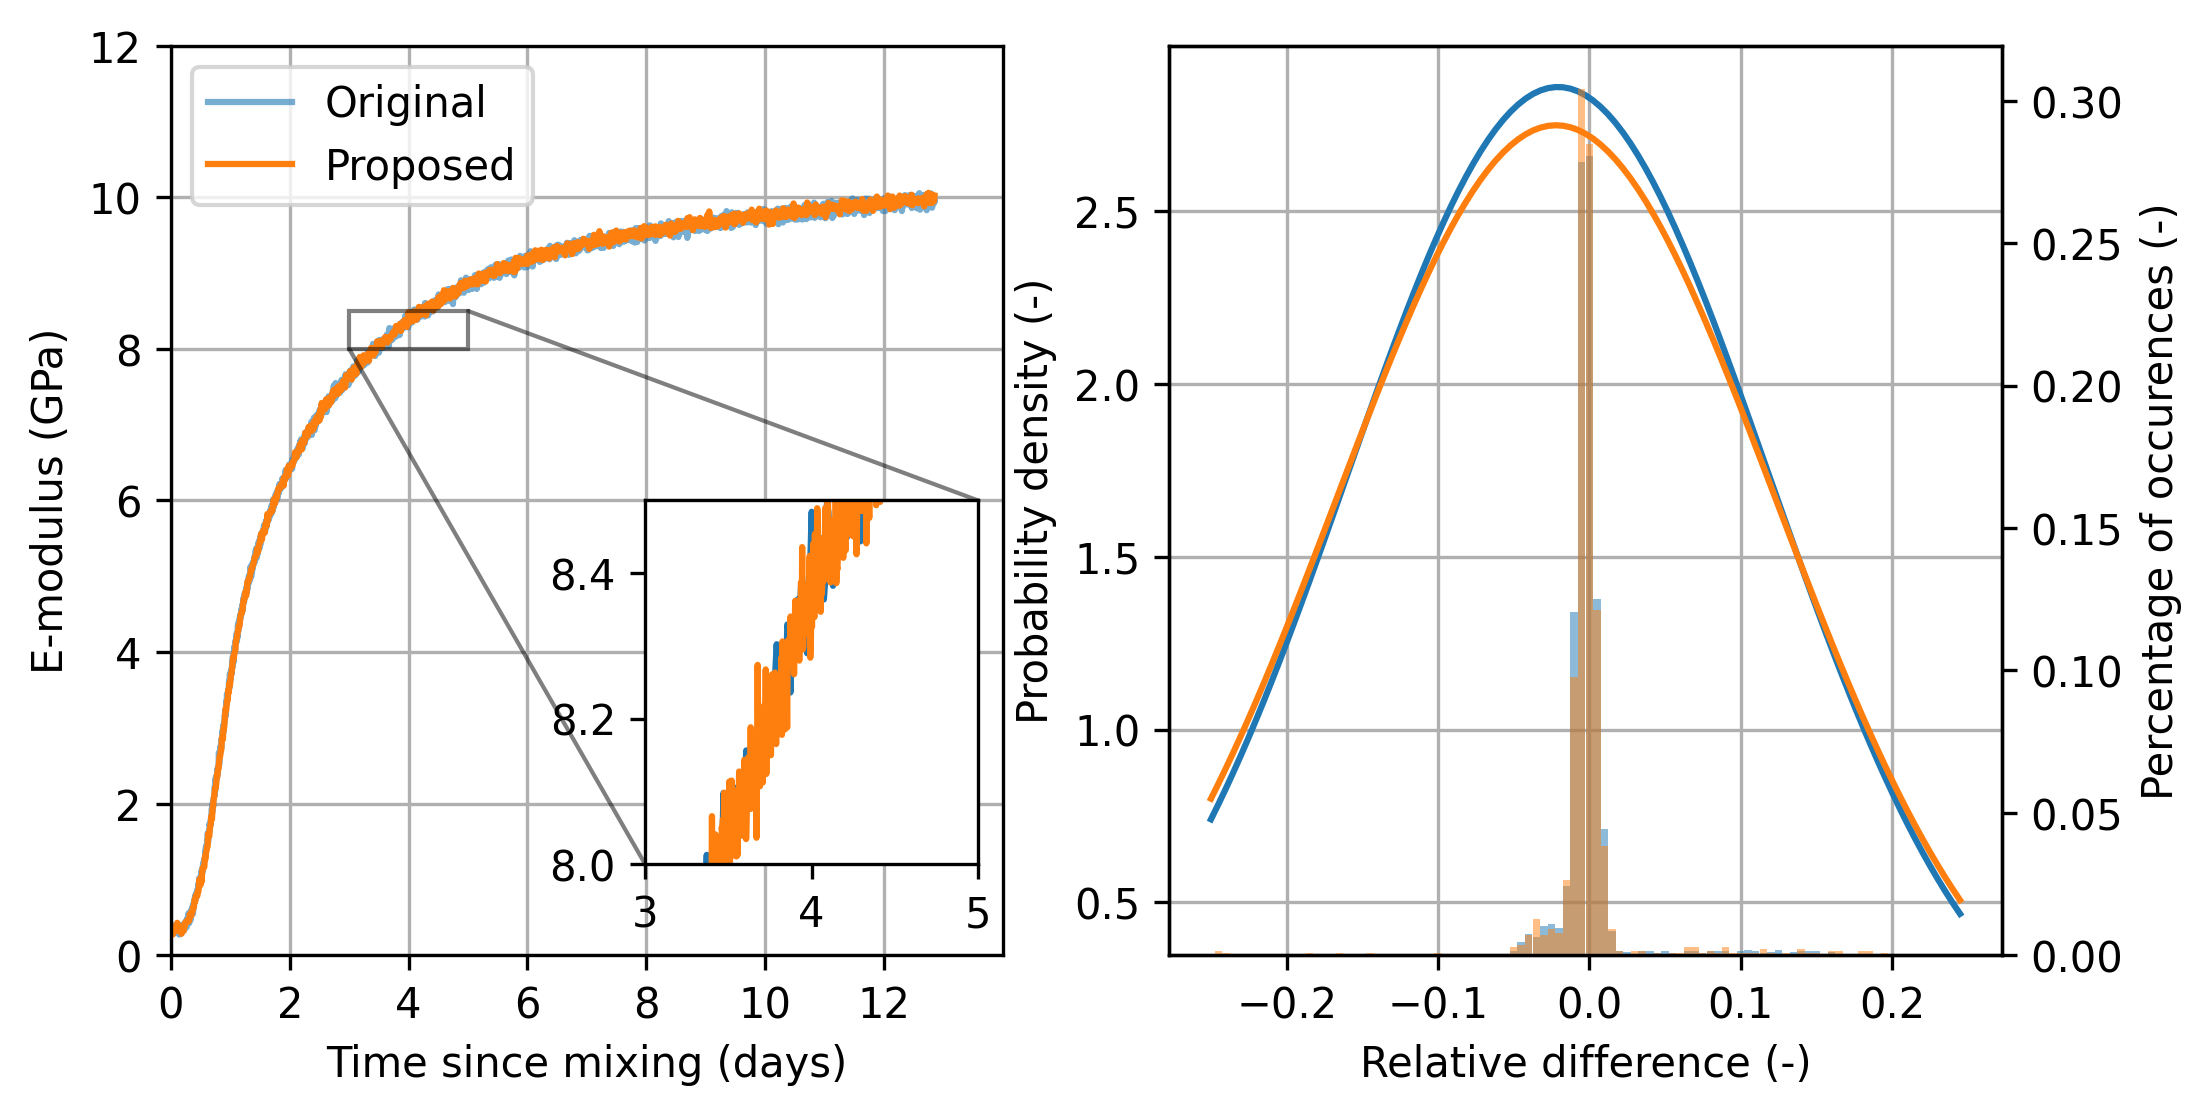

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

#Module for selecting files
from tkinter import Tk, filedialog

#Module to deal with files from the system
import os

#Factor to convert seconds to days
timeFactor = 60*60*24
sizeScatter=20
alphaScatter1=0.6
alphaScatter2=1

#Histogram
numOfBins=100
minBin=-0.25
maxBin=0.25
widthOfBinBars=(maxBin-minBin)/(numOfBins+1)
alphaBin=0.5

#Files to be read
file1='D:/Documentos/OneDrive/Renan/Engenharia Civil/Ensaios/220406-EMMARM_COMPARISON_JPEE/20220406-1200-1ST_BATCH/00-POST_PROCESSED/uEMMARM-1_modulusElasticity.txt'
file2='D:/Documentos/OneDrive/Renan/Engenharia Civil/Ensaios/220406-EMMARM_COMPARISON_JPEE/20220406-1200-1ST_BATCH/00-POST_PROCESSED/National-1_modulusElasticity.txt'

#Set figure generally
cm = 1/2.54  # centimeters in inches
#Set Matplotlib plot
fig, ax = plt.subplots(1, 2, figsize=(20*cm, 10*cm))

#Read the data generated from the E-modulus estimation
# Get the path of the file to be read
#pathForFile = filedialog.askopenfile(title="Select E-modulus evolution curve")
modulusEvolutionData = np.loadtxt(file2, dtype='float', delimiter='\t')
#pathForFile.close()

#Read the data generated from the E-modulus estimation
# Get the path of the file to be read
#pathForFile = filedialog.askopenfile(title="Select E-modulus evolution curve")
modulusEvolutionData = np.loadtxt(file1, dtype='float', delimiter='\t')
#pathForFile.close()

#Extract data
modulus2 = modulusEvolutionData[:,1]
ages2 = modulusEvolutionData[:,0]
#Create the vector that will store the predicted composite flexural stiffness
#ax.scatter(ages/timeFactor,modulus/1e9, s=sizeScatter, label='uEMMARM',alpha=alphaScatter, edgecolors='none')
ax[0].plot(ages2/timeFactor,modulus2/1e9, label='Proposed',alpha=alphaScatter2)

#Extract data
modulus = modulusEvolutionData[:,1]
ages = modulusEvolutionData[:,0]
#Create the vector that will store the predicted composite flexural stiffness
#ax.scatter(ages/timeFactor,modulus/1e9, s=sizeScatter, label='National',alpha=alphaScatter, edgecolors='none')
ax[0].plot(ages/timeFactor,modulus/1e9, label='Original',alpha=alphaScatter1)

#Set graph visualization options
ax[0].set(xlabel='Time since mixing (days)', ylabel='E-modulus (GPa)')
ax[0].grid()
ax[0].set_xlim([0, 14])
ax[0].set_ylim([0, 12])
ax[0].legend()
ax[0].set_xticks(np.arange(0, 14, 2))

# inset axes....
axins = ax[0].inset_axes([0.57, 0.10, 0.4, 0.4])
axins.plot(ages/timeFactor,modulus/1e9)
axins.plot(ages2/timeFactor,modulus2/1e9)
# sub region of the original image
x1, x2, y1, y2 = 3, 5, 8, 8.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
#axins.set_xticklabels([])
#axins.set_yticklabels([])
ax[0].indicate_inset_zoom(axins, edgecolor="black",label='_nolegend_')
'''
#Show figure
plt.savefig("modulusEvolution.svg", dpi='figure')
plt.show()
'''

## Fitting data
#Fit curve
from scipy.optimize import curve_fit
import scipy.stats
import statistics

#Arrhenius equation with two-terms
def ArrheniusFuntionTwoTerms(x, alfa1, beta1, tau1):
    #y = alfa1*np.exp((-(tau1/x))**beta1)
    y = alfa1*np.exp(-((tau1/x)**beta1))
    return y

#Do this for National
parameters, covariance = curve_fit(ArrheniusFuntionTwoTerms, ages/timeFactor, modulus/1e9)
[fit_alfa1, fit_beta1, fit_tau1]=parameters
fit_modulus = ArrheniusFuntionTwoTerms(ages/timeFactor, fit_alfa1, fit_beta1, fit_tau1)
averagedDifferences = np.divide(fit_modulus - (modulus/1e9), modulus/(1e9))

#plt.hist(averagedDifferences, bins=100)
mean1 = statistics.mean(averagedDifferences)
sd1 = statistics.stdev(averagedDifferences)
hist1, bins1 = np.histogram(averagedDifferences, numOfBins, (minBin,maxBin))

pltX1 = np.arange(minBin, maxBin, widthOfBinBars)
ln1=ax[1].plot(pltX1, scipy.stats.norm.pdf(pltX1, mean1, sd1), label='Original')

#Do this for uEMMARM
parameters2, covariance2 = curve_fit(ArrheniusFuntionTwoTerms, ages2/timeFactor, modulus2/1e9)
[fit_alfa1_2, fit_beta1_2, fit_tau1_2]=parameters2
fit_modulus2 = ArrheniusFuntionTwoTerms(ages2/timeFactor, fit_alfa1_2, fit_beta1_2, fit_tau1_2)
averagedDifferences2 = np.divide(fit_modulus2 - (modulus2/1e9), modulus2/(1e9))

#plt.hist(averagedDifferences, bins=100)
mean2 = statistics.mean(averagedDifferences2)
sd2 = statistics.stdev(averagedDifferences2)
hist2, bins2 = np.histogram(averagedDifferences2, numOfBins, (minBin,maxBin))

pltX2 = np.arange(minBin, maxBin, widthOfBinBars)
ln2=ax[1].plot(pltX2, scipy.stats.norm.pdf(pltX2, mean2, sd2), label='Proposed')


#Plot the histograns
ax2 = ax[1].twinx()
ln3=ax2.bar(bins1[:-1],hist1/len(modulus), width=widthOfBinBars, color='tab:blue', alpha=alphaBin, label="Original histo")
ln4=ax2.bar(bins2[:-1],hist2/len(modulus2), width=widthOfBinBars, color='tab:orange', alpha=alphaBin, label="Proposed histo")

#Set graph visualization options
ax[1].set(xlabel='Relative difference (-)', ylabel='Probability density (-)')
ax2.set(ylabel='Percentage of occurences (-)')
ax[1].grid()
#plt.axis([-0.5, 0.5, 0, 3])

#Show figure
'''
colors = {'Original':'tab:blue', 'Proposed':'tab:orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='lower left', prop={'size': 8})
plt.savefig("probability.svg", dpi='figure')
plt.show()
'''
fig.savefig("modulusEvolution.svg", dpi='figure')
fig.show()

In [33]:
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>